In [1]:
using DrWatson
@quickactivate "BayesWorkshop2021"
include(joinpath(srcdir(), "setup.jl"));

## The problem

### Background

Imagine that you are a statistician or data scientist working as an independent
contractor. One of your clients is a company that owns many residential buildings
throughout New York City. The property manager explains that they are concerned about the number
of cockroach complaints that they receive from their buildings. Previously
the company has offered monthly visits from a pest inspector as a solution to
this problem. While this is the default solution of many property managers in
NYC, the tenants are rarely home when the inspector visits, and so the manager
reasons that this is a relatively expensive solution that is currently not very
effective.

One alternative to this problem is to deploy long term bait stations. In this
alternative, child and pet safe bait stations are installed throughout the
apartment building. Cockroaches obtain quick acting poison from these stations
and distribute it throughout the colony. The manufacturer of these bait stations
provides some indication of the space-to-bait efficacy, but the manager suspects
that this guidance was not calculated with NYC roaches in mind. NYC roaches, the
manager rationalizes, have more hustle than traditional roaches; and NYC
buildings are built differently than other common residential buildings in the
US. This is particularly important as the unit cost for each bait station per
year is quite high.

### The goal

The manager wishes to employ your services to help them to find the optimal
number of roach bait stations they should place in each of their buildings in
order to minimize the number of cockroach complaints while also keeping
expenditure on pest control affordable.

A subset of the company's buildings have been randomly selected for an experiment:

* At the beginning of each month, a pest inspector randomly places a number of
bait stations throughout the building, without knowledge of the current
cockroach levels in the building
* At the end of the month, the manager records
the total number of cockroach complaints in that building.
* The manager would like to determine the optimal number of traps ($\textrm{traps}$) that
balances the lost revenue ($R$) that complaints ($\textrm{complaints}$) generate
with the all-in cost of maintaining the traps ($\textrm{TC}$).

Fortunately, Bayesian data analysis provides a coherent framework for us to tackle this problem.

Formally, we are interested in finding

$$
\arg\max_{\textrm{traps} \in \mathbb{N}} \mathbb{E}_{\text{complaints}}[R(\textrm{complaints}(\textrm{traps})) - \textrm{TC}(\textrm{traps})]
$$

The property manager would also, if possible, like to learn how these results
generalize to buildings they haven't treated so they can understand the
potential costs of pest control at buildings they are acquiring as well as for
the rest of their building portfolio.

As the property manager has complete control over the number of traps set, the
random variable contributing to this expectation is the number of complaints
given the number of traps. We will model the number of complaints as a function
of the number of traps.

## The data

The data provided to us is in a file called `pest_data.feather`. Let's
load the data and see what the structure is:

We have access to the following fields:

* `complaints`: Number of complaints per building per month
* `building_id`: The unique building identifier
* `traps`: The number of traps used per month per building
* `date`: The date at which the number of complaints are recorded
* `live_in_super`: An indicator for whether the building as a live-in super
* `age_of_building`: The age of the building
* `total_sq_foot`: The total square footage of the building
* `average_tenant_age`: The average age of the tenants per building
* `monthly_average_rent`: The average monthly rent per building
* `floors`: The number of floors per building

First, let's see how many buildings we have data for:

In [2]:
n_buildings = length(unique(pest_data.building_id))

10

And make some plots of the raw data:

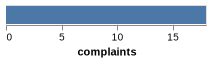

In [3]:
using VegaLite

pest_data |>
@vlplot(
  :bar,
  x = :complaints
)

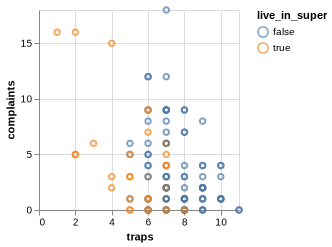

In [4]:
pest_data |>
@vlplot(
  :point,
  x = :traps,
  y = :complaints,
  color = "live_in_super:N"
)

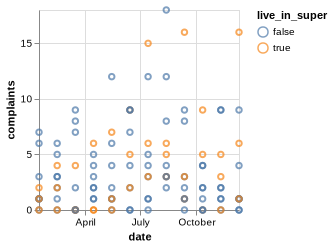

In [5]:
pest_data |>
@vlplot(
  :point,
  x = :date,
  y = :complaints,
  color = "live_in_super:N"
)

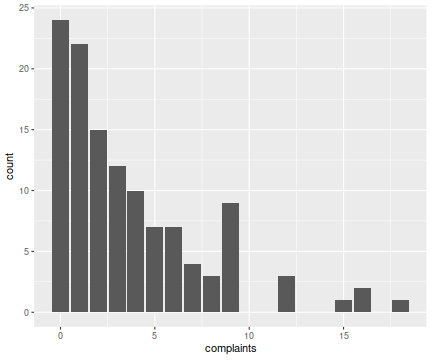

RObject{VecSxp}


In [6]:
using RCall
ggplot = rimport("ggplot2")

ggplot.ggplot(pest_data, ggplot.aes(x = :complaints)) + ggplot.geom_bar()

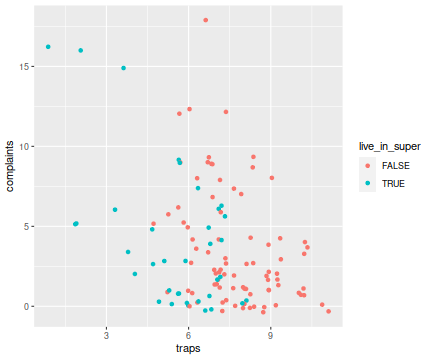

RObject{VecSxp}


In [7]:
ggplot.ggplot(pest_data, ggplot.aes(x = :traps, y = :complaints, color = :live_in_super)) + ggplot.geom_jitter()

The first question we'll look at is just whether the number of complaints per
building per month is associated with the number of bait stations per building
per month, ignoring the temporal and across-building variation (we'll come back
to those sources of variation later in the document). That requires only two
variables, $\textrm{complaints}$ and $\textrm{traps}$. How should we model the
number of complaints?


## Bayesian workflow

See slides

## Modeling count data : Poisson distribution

We already know some rudimentary information about what we should expect. The
number of complaints over a month should be either zero or an integer. The
property manager tells us that it is possible but unlikely that number of
complaints in a given month is zero. Occasionally there are a very large number
of complaints in a single month. A common way of modeling this sort of skewed,
single bounded count data is as a Poisson random variable. One concern about
modeling the outcome variable as Poisson is that the data may be
over-dispersed, but we'll start with the Poisson model and then check
whether over-dispersion is a problem by comparing our model's predictions
to the data.

### Model

Given that we have chosen a Poisson regression, we define the likelihood to be
the Poisson probability mass function over the number bait stations placed in
the building, denoted below as `traps`. This model assumes that the mean and
variance of the outcome variable `complaints` (number of complaints) is the
same. We'll investigate whether this is a good assumption after we fit the
model.

For building $b = 1,\dots,10$ at time (month) $t = 1,\dots,12$, we have

$$
\begin{align*}
\textrm{complaints}_{b,t} & \sim \textrm{Poisson}(\lambda_{b,t}) \\
\lambda_{b,t} & = \exp{(\eta_{b,t})} \\
\eta_{b,t} &= \alpha + \beta \, \textrm{traps}_{b,t}
\end{align*}
$$

Let's encode this probability model in a Turing model.

### Writing our first model

In [8]:
using Turing

@model function simple_poisson(; traps, complaints=missing)
    α ~ Normal(log(4), .1)
    β ~ Normal(-0.25, .1)

    # This will be compiled away by Julia's compiler, i.e.
    # it has zero cost at runtime. It allows us to use `.~`
    # both to sample and observe.
    if complaints === missing
        complaints = Vector{Int}(undef, length(traps))
    end

    @. complaints ~ Poisson(exp(α + β * traps))

    return (; α, β, complaints)
end

simple_poisson (generic function with 1 method)

### Making sure our code is right

However, before we fit the model to real data, we should check that our
model works well with simulated data. We'll simulate data according to the model
and then check that we can sufficiently recover the parameter values used
in the simulation. We can simulate the data by calling the `rand()` method on
our model.

In [9]:
N = size(pest_data, 1)
mean_traps = mean(pest_data.traps)
fake_traps = rand(filldist(Poisson(mean_traps), N));

### Fit the model to the fake data:
A Turing `Model` is really just a function, hence we can get a sample 
of the return-values under the prior, which in our case is all the parameters in the model,
by simply calling the instantiated model. Hence we just instantiate the model
on the `fake_traps` and call it:

In [10]:
fake_model = simple_poisson(traps=fake_traps);
fake_data = fake_model();
fake_complaints = fake_data.complaints;
fake_data

(α = 1.4406201818418811, β = -0.36138044521818524, complaints = [0, 1, 0, 1, 1, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 1, 1, 0, 1, 2, 1])

Now that we have the simulated data we fit the model to see if we can recover
the `alpha` and `beta` parameters used in the simulation.

### Assess parameter recovery

To condition `simple_poisson` we simply override the `missing` default value for `complaints`:

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


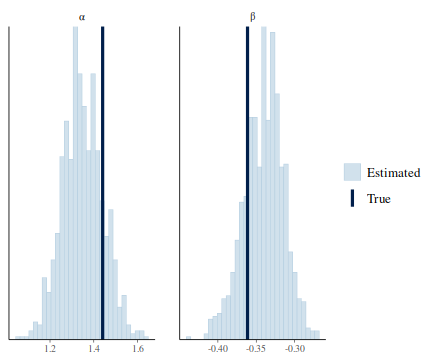

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160


In [11]:
fake_post = sample(simple_poisson(traps=fake_traps, complaints=fake_complaints), NUTS(), 1_000)
mcmc_recover_hist(fake_post, (α = fake_data.α, β = fake_data.β))

We don't do a great job recovering the parameters here simply because we're
simulating so few observations that the posterior uncertainty remains rather
large, but it looks at least _plausible_ ($\alpha$ and $\beta$ are contained
within the histograms). If we did the simulation with many more observations the
parameters would be estimated much more precisely.

To get a better sense of the fit it's useful to look at the in-sample predictions.
We simply re-instantiate the model but now with `complaints=missing` again, and then
sample from the model _conditioned_ on the chain `fake_post` using `predict`.

In [12]:
# Note: `posterior_predictive` is just a wrapper around `Turing.predict`
# so we instead end up working with a `Vector{<:NamedTuple}` instead of
# a `MCMCChains.Chains`. This is to stay consistent with the other tutorials
# e.g. Soss.jl's tutorial.
yrep = posterior_predictive(simple_poisson(traps=fake_traps), fake_post)

1000-element Vector{NamedTuple{(:complaints,), Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}:
 (complaints = [0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0],)
 (complaints = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0  …  0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0],)
 (complaints = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],)
 (complaints = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)
 (complaints = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3.0, 0.0, 1.0  …  1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0],)
 (complaints = [0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0],)
 (complaints = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0],)
 (compl

Here is a plot of the density estimate of the observed data compared to
200 of the `yrep` datasets:

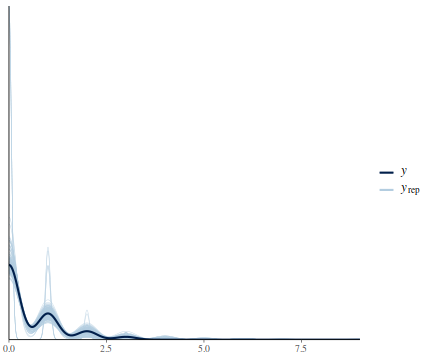

RObject{VecSxp}


In [13]:
ppc_dens_overlay(fake_complaints, yrep[1:200])

In the plot above we have the kernel density estimate of the observed data ($y$,
thicker curve) and 200 simulated data sets ($y_{rep}$, thin curves) from the
posterior predictive distribution. If the model fits the data well, as it does
here, there is little difference between the observed dataset and the simulated
datasets.

Another plot we can make for count data is a rootogram. This is a plot of the
expected counts (continuous line) vs the observed counts (blue histogram). We
can see the model fits well because the observed histogram matches the expected
counts relatively well.

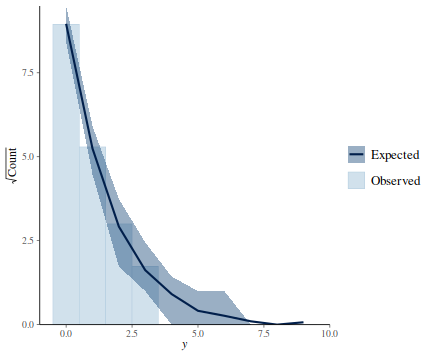

RObject{VecSxp}


In [14]:
ppc_rootogram(fake_complaints, yrep[1:200])

### Fit with real data

To fit the model to the actual observed data, again, we just set the `complaints` to
the observations and `sample`:

In [15]:
post = sample(simple_poisson(traps=pest_data.traps, complaints=pest_data.complaints), NUTS(), 1_000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/tor/.julia/packages/AdvancedHMC/bv9VV/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/tor/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.21 seconds
Compute duration  = 0.21 seconds
parameters        = α, β
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           α    1.7223    0.0826     0.0026    0.0040   233.1861    0.9991     ⋯
           β   -0.0734    0.0132     0.0004    0.0006   230.1460    0.9993     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           

We can also plot the posterior distributions:

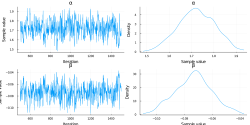

In [16]:
using StatsPlots
plot(post)

As we expected, it appears the number of bait stations set in a building is
associated with the number of complaints about cockroaches that were made in the
following month. However, we still need to consider how well the model fits the data.


### Posterior predictive checking

Let's produce some samples of `complaints` given the chain `post`:

In [17]:
yrep = posterior_predictive(simple_poisson(traps=pest_data.traps), post)

1000-element Vector{NamedTuple{(:complaints,), Tuple{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}}}:
 (complaints = [3.0, 2.0, 1.0, 1.0, 3.0, 3.0, 5.0, 8.0, 1.0, 2.0  …  3.0, 2.0, 3.0, 5.0, 0.0, 2.0, 1.0, 6.0, 5.0, 5.0],)
 (complaints = [7.0, 8.0, 1.0, 3.0, 2.0, 3.0, 1.0, 3.0, 5.0, 2.0  …  2.0, 2.0, 6.0, 5.0, 5.0, 2.0, 5.0, 3.0, 9.0, 3.0],)
 (complaints = [1.0, 3.0, 4.0, 3.0, 6.0, 1.0, 1.0, 2.0, 5.0, 6.0  …  2.0, 3.0, 4.0, 4.0, 7.0, 3.0, 6.0, 3.0, 6.0, 2.0],)
 (complaints = [4.0, 9.0, 2.0, 5.0, 3.0, 1.0, 3.0, 4.0, 5.0, 2.0  …  5.0, 2.0, 3.0, 3.0, 5.0, 9.0, 3.0, 2.0, 5.0, 7.0],)
 (complaints = [1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 3.0, 2.0  …  3.0, 5.0, 1.0, 6.0, 1.0, 1.0, 3.0, 6.0, 7.0, 3.0],)
 (complaints = [3.0, 3.0, 1.0, 3.0, 2.0, 5.0, 0.0, 3.0, 1.0, 2.0  …  2.0, 4.0, 7.0, 1.0, 4.0, 6.0, 6.0, 4.0, 7.0, 4.0],)
 (complaints = [1.0, 4.0, 1.0, 3.0, 4.0, 6.0, 5.0, 3.0, 0.0, 6.0  …  1.0, 2.0, 5.0, 4.0, 7.0, 3.0, 6.0, 5.0, 2.0, 3.0],)
 (compl

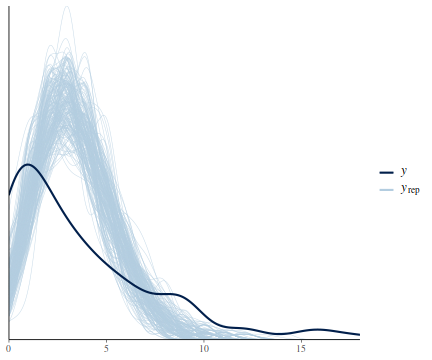

RObject{VecSxp}


In [18]:
ppc_dens_overlay(pest_data.complaints, yrep[1:200])

As opposed to when we fit the model to simulated data above, here the simulated
datasets is not as dispersed as the observed data and don't seem to capture the
rate of zeros in the observed data. The Poisson model may not be sufficient for
this data.

Let's explore this further by looking directly at the proportion of zeros in the
real data and predicted data.

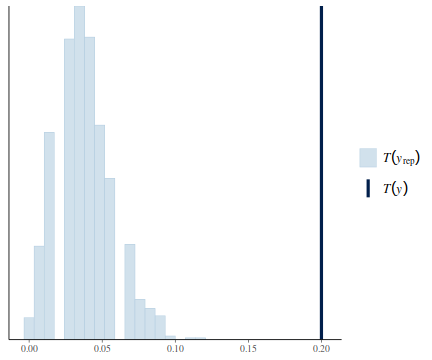

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/tor/.julia/packages/RCall/iMDW2/src/io.jl:160


In [19]:
ppc_stat(pest_data.complaints, yrep, stat = R"function(x) mean(x == 0)")

The plot above shows the observed proportion of zeros (thick vertical line) and
a histogram of the proportion of zeros in each of the simulated data sets. It is
clear that the model does not capture this feature of the data well at all.

This next plot is a plot of the standardised residuals of the observed vs predicted number of complaints.

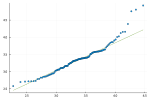

In [20]:
# Convert into a matrix of size `(num_variables, num_samples)`
yrep_matrix = mapreduce(hcat, yrep) do y
    y.complaints
end;

qqnorm(dropdims(mean(yrep_matrix; dims=2); dims=2), qqline=:R)

As you can see here, it looks as though we have more positive residuals than negative,
which indicates that the model tends to underestimate the number of complaints
that will be received.

The rootogram is another useful plot to compare the observed vs expected number
of complaints. This is a plot of the expected counts (continuous line) vs the
observed counts (blue histogram):

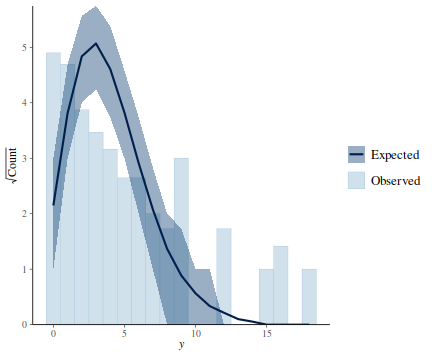

RObject{VecSxp}


In [21]:
ppc_rootogram(pest_data.complaints, yrep)

If the model was fitting well these would be relatively similar, however in this
figure we can see the number of complaints is underestimated if there are few
complaints, over-estimated for medium numbers of complaints, and underestimated
if there are a large number of complaints.

We can also view how the predicted number of complaints varies with the number
of traps. From this we can see that the model doesn't seem to fully capture the
data.

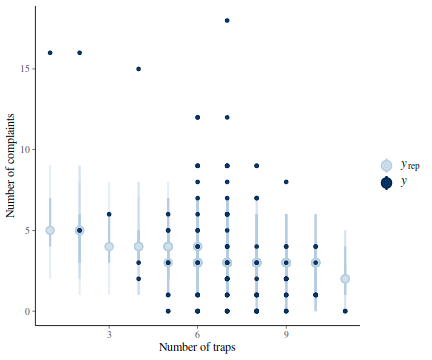

RObject{VecSxp}


In [22]:
ppc_intervals(pest_data.complaints, yrep, x = pest_data.traps) + ggplot.labs(x = "Number of traps", y = "Number of complaints")

Specifically, the model doesn't capture the tails of the observed data very
well.

### ArviZ.jl

The above closely follows the original Stan tutorial, but often it will be more convenient to reach for other Julia packages to perform visualization and posterior analysis. In particular, [ArviZ.jl](https://github.com/arviz-devs/ArviZ.jl) provides a signficant toolbox for doing posterior analysis and model comparison, e.g. some of the plots from above becomes a simple function call. Throughout we'll therefore make use of following `to_arviz` method:

In [23]:
using ArviZ, LinearAlgebra

# https://arviz-devs.github.io/ArviZ.jl/stable/quickstart/#Convert-to-InferenceData
function to_arviz(prior_model::Turing.Model, conditioned_model::Turing.Model, posterior_samples::MCMCChains.Chains)
    # Sample from the prior of the latent variables, i.e. everything
    # except `complaints`.
    prior_samples = sample(conditioned_model, Prior(), 1_000, progress=false);
    # Sample "predictions" of `complaints` under `prior_samples`.
    prior_predictive = predict(prior_model, prior_samples);
    # Sample predictions of `complains` under `posterior_samples`.
    posterior_predictive = predict(prior_model, posterior_samples);
    # Compute p(constraints[i] ∣ params...) where `params` are given
    # by samples form `posterior_samples`.
    loglikelihoods = Turing.pointwise_loglikelihoods(
        conditioned_model,
        MCMCChains.get_sections(posterior_samples, :parameters)
    );

    # Ensure the ordering of the loglikelihoods matches the ordering of `posterior_predictive`.
    ynames = string.(keys(posterior_predictive));
    loglikelihoods_vals = getindex.(Ref(loglikelihoods), ynames);
    # Reshape into `(nchains, nsamples, size(y)...)`
    loglikelihoods_arr = permutedims(cat(loglikelihoods_vals...; dims=3), (2, 1, 3));

    # Finally convert into `InferenceData`.
    return from_mcmcchains(
        posterior_samples;
        posterior_predictive=posterior_predictive,
        log_likelihood=Dict("complaints" => loglikelihoods_arr),
        prior=prior_samples,
        prior_predictive=prior_predictive,
        observed_data=Dict("complaints" => conditioned_model.args.complaints),
        library="Turing",
    )
end

to_arviz (generic function with 1 method)

This is in fact included in `setup.jl` but we also include it here for demonstration purposes. This means that we can now do:

In [24]:
idata = to_arviz(
    simple_poisson(traps=pest_data.traps),
    simple_poisson(traps=pest_data.traps, complaints=pest_data.complaints),
    post
)

InferenceData with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

giving us an `InferenceData` instance, which in turn gives us access to ArviZ's toolbox, e.g. we can compare the prior distribution and the posterior distribution to see if we actually learned anything by calling `plot_dist_comparison`:

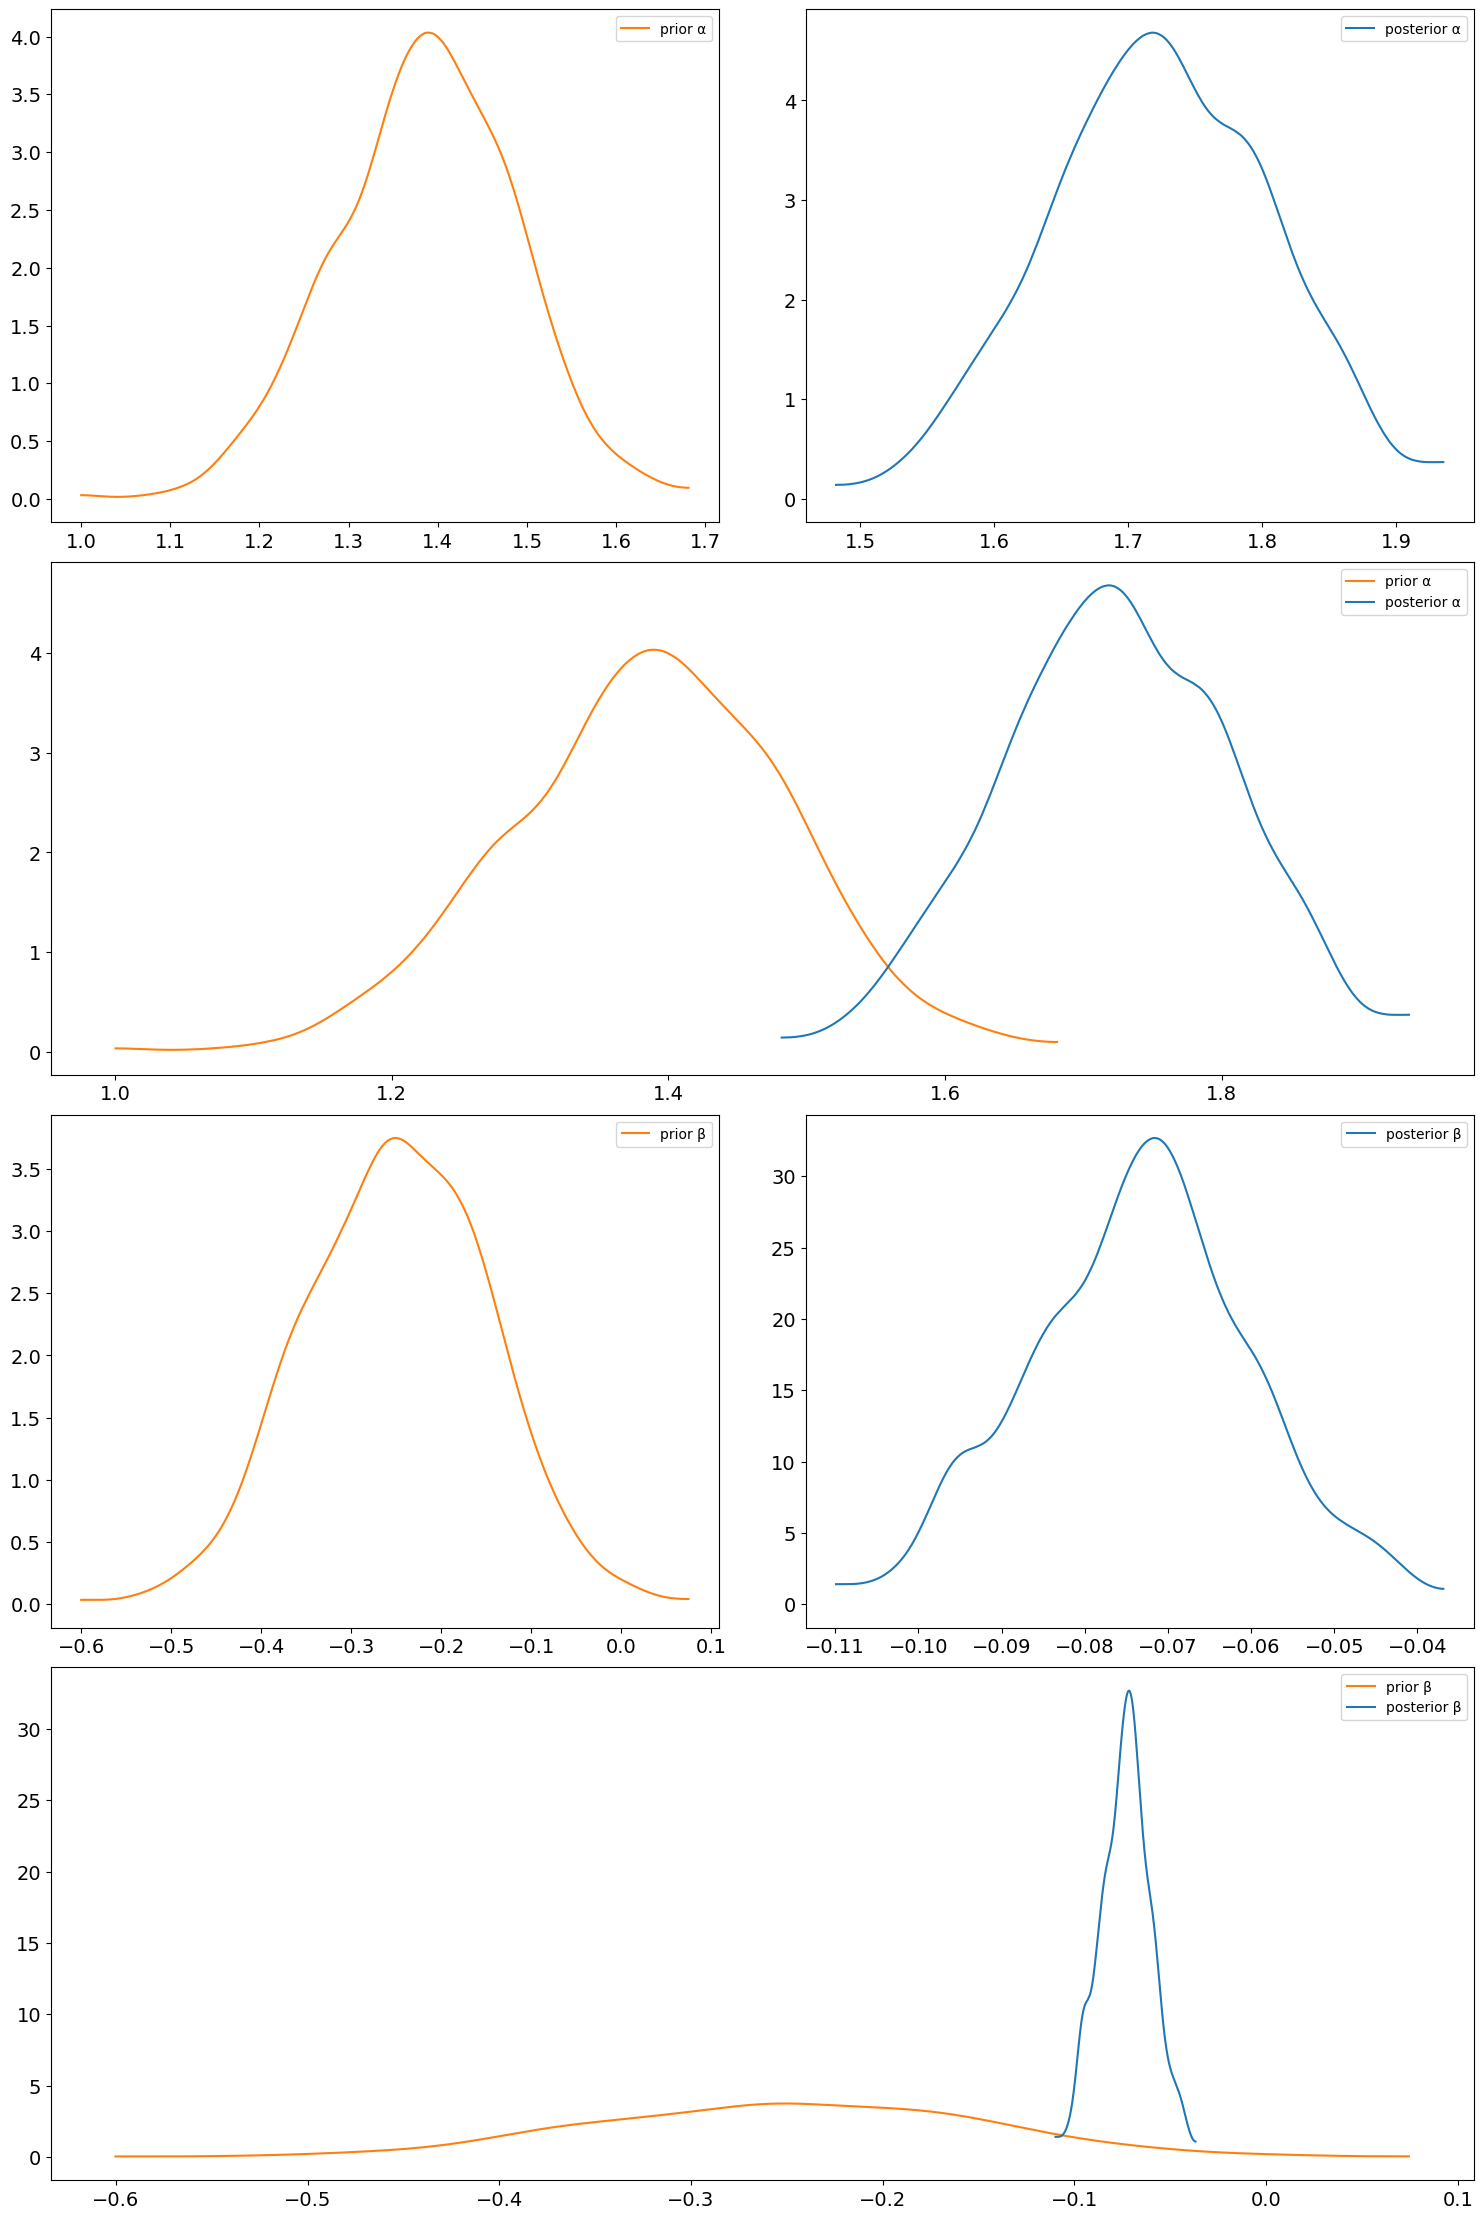

2×3 Matrix{PyCall.PyObject}:
 PyObject <AxesSubplot:>  PyObject <AxesSubplot:>  PyObject <AxesSubplot:>
 PyObject <AxesSubplot:>  PyObject <AxesSubplot:>  PyObject <AxesSubplot:>

In [25]:
plot_dist_comparison(idata)

Hey, we did! Or equivalent of the `ppc_dens_overlay` from above:

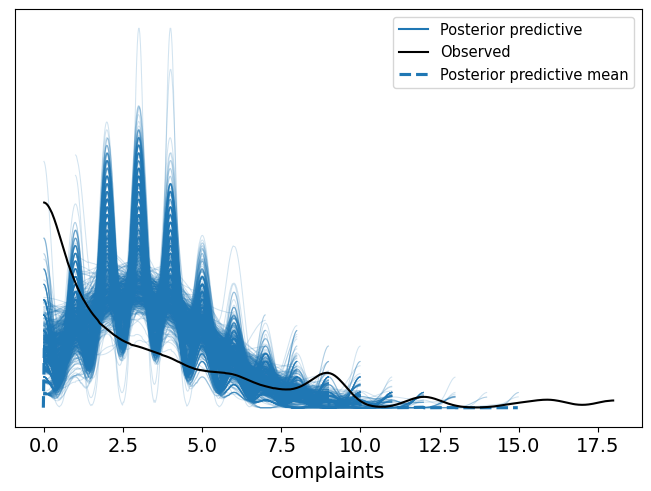

PyObject <AxesSubplot:xlabel='complaints'>

In [26]:
plot_ppc(idata)

We'll be using more of ArviZ's functionality later on.